# Advanced Certification Programme in AI and MLOps
## A programme by IISc and TalentSprint
### Mini Project Notebook: Employee Attrition Prediction

## Problem Statement

To predict employee attrition using CatBoost and XgBoost

## Learning Objectives

At the end of the experiment, you will be able to

* explore the employee attrition dataset
* apply CatBoost and XgBoost on the dataset
* tune the model hyperparameters to improve accuracy
* evaluate the model using suitable metrics


## Introduction

Employee attrition is the gradual reduction in employee numbers. Employee attrition happens when the size of your workforce diminishes over time. This means that employees are leaving faster than they are hired. Employee attrition happens when employees retire, resign, or simply aren't replaced.
Although employee attrition can be company-wide, it may also be confined to specific parts of a business.

Employee attrition can happen for several reasons. These include unhappiness about employee benefits or the pay structure, a lack of employee development opportunities, and even poor conditions in the workplace.

To know more about the factors that lead to employee attrition, refer [here](https://www.betterup.com/blog/employee-attrition#:~:text=Employee%20attrition%20is%20the%20gradual,or%20simply%20aren't%20replaced).


**Gradient Boosted Decision Trees**

* Gradient boosted decision trees (GBDTs) are one of the most important machine learning models.

* GBDTs originate from AdaBoost, an algorithm that ensembles weak learners and uses the majority vote, weighted by their individual accuracy, to solve binary classification problems. The weak learners in this case are decision trees with a single split, called decision stumps.

* Some of the widely used gradient boosted decision trees are XgBoost, CatBoost and LightGBM.

## Dataset

The dataset used for this mini-project is [HR Employee Attrition dataset](https://data.world/aaizemberg/hr-employee-attrition). This dataset is synthetically created by IBM data scientists. There are 35 features and 1470 records.

There are numerical features such as:

* Age
* DistanceFromHome
* EmployeeNumber
* PerformanceRating

There are several categorical features such as:
* JobRole
* EducationField
* Department
* BusinessTravel

Dependent or target feature is 'attrition' which has values as Yes/No.

In [1]:
#@title Download the data
!wget -qq https://cdn.iisc.talentsprint.com/CDS/Datasets/wa_fn_usec_hr_employee_attrition_tsv.csv
print("Data Downloaded Successfuly!!")

Data Downloaded Successfuly!!


## Grading = 10 Points

### Install Required Dependencies

In [2]:
# Install CatBoost
!pip -qq install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 MB 7.3 MB/s eta 0:00:00


### Import Required Packages

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, f1_score
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier, metrics
import warnings
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
pd.set_option('display.max_columns', 100)
%matplotlib inline

Please refer to the [ReadMe](https://drive.google.com/file/d/170bz7lrIWBn_lExdKStU5cULA0amKxUX/view?usp=sharing) before proceeding further.

# Part-A

## Load the Dataset

**Exercise 1: Read the dataset [0.5 Mark]**

**Hint:** pd.read_csv()

In [60]:
# read the dataset
data = pd.read_csv('wa_fn_usec_hr_employee_attrition_tsv.csv')

In [61]:
# Check the shape of dataframe.
data.shape

(1470, 35)

## Data Exploration

- Check for missing values
- Check for features having consistent data across samples
- Check for outliers or inconsistencies in data columns
- Check for correlated features
- Do we have a target label imbalance
- How our independent variables are distributed relative to our target label
- Are there features that have strong linear or monotonic relationships? Making correlation heatmaps makes it easy to identify possible collinearity

**Exercise 2: Create a `List` of numerical and categorical columns. Display a statistical description of the dataset. Remove missing values (if any) [0.5 Mark]**

**Hint:**
>Use `for` to iterate through each column.

>For statistical description display - samples count, missing values count, range, and data type of each feature.

In [65]:
# YOUR CODE HERE
# As per the dataframe given, below mentioned are the numerical and categorical columns available.
num_cols = data.select_dtypes(exclude='object').columns
cat_cols = data.select_dtypes(include='object').columns

print('Number of categorical columns: ', len(cat_cols))
print('Categorical columns: ', cat_cols)
print('Number of numeric columns:', len(num_cols))
print('Numeric columns: ', num_cols)

Number of categorical columns:  9
Categorical columns:  Index(['attrition', 'businesstravel', 'department', 'educationfield', 'gender',
       'jobrole', 'maritalstatus', 'over18', 'overtime'],
      dtype='object')
Number of numeric columns: 26
Numeric columns:  Index(['age', 'dailyrate', 'distancefromhome', 'education', 'employeecount',
       'employeenumber', 'environmentsatisfaction', 'hourlyrate',
       'jobinvolvement', 'joblevel', 'jobsatisfaction', 'monthlyincome',
       'monthlyrate', 'numcompaniesworked', 'percentsalaryhike',
       'performancerating', 'relationshipsatisfaction', 'standardhours',
       'stockoptionlevel', 'totalworkingyears', 'trainingtimeslastyear',
       'worklifebalance', 'yearsatcompany', 'yearsincurrentrole',
       'yearssincelastpromotion', 'yearswithcurrmanager'],
      dtype='object')


In [45]:
# Check for outliers
col_stats_info = []
unique_cat_info = []

for col in data.columns:
    stats_dict = dict()
    cat_uniq_values_dict = dict()
    stats_dict['column_name'] = col
    stats_dict['samples_count'] = data[col].count()
    stats_dict['missing_val_count'] = data[col].isna().sum()
    if data[col].dtype != 'object':
        stats_dict['col_range'] = data[col].max() - data[col].min()
        stats_dict['max_value'] = data[col].max()
        stats_dict['min_value'] = data[col].min()
    else:
        stats_dict['col_range'] = np.nan
        stats_dict['modal_class'] = data[col].mode()[0]
        stats_dict['num_of_classes'] = data[col].nunique()
        cat_uniq_values_dict['column_name'] = col
        cat_uniq_values_dict['classes'] = data[col].unique()
    stats_dict['col_dtype'] = data[col].dtype

    col_stats_info.append(stats_dict)
    unique_cat_info.append(cat_uniq_values_dict)


stats_df = pd.DataFrame.from_dict(col_stats_info)
stats_df

column_name  samples_count  missing_val_count  col_range  \
0                        age           1470                  0       42.0   
1                  attrition           1470                  0        NaN   
2             businesstravel           1470                  0        NaN   
3                  dailyrate           1470                  0     1397.0   
4                 department           1470                  0        NaN   
5           distancefromhome           1470                  0       28.0   
6                  education           1470                  0        4.0   
7             educationfield           1470                  0        NaN   
8              employeecount           1470                  0        0.0   
9             employeenumber           1470                  0     2067.0   
10   environmentsatisfaction           1470                  0        3.0   
11                    gender           1470                  0        NaN   
12                hourlyrate           1470                  0       70.0   
13            jobinvolvement           1470                  0        3.0   
14                  joblevel           1470                  0        4.0   
15                   jobrole           1470                  0        NaN   
16           jobsatisfaction           1470                  0        3.0   
17             maritalstatus           1470                  0        NaN   
18             monthlyincome           1470                  0    18990.0   
19               monthlyrate           1470                  0    24905.0   
20        numcompaniesworked           1470                  0        9.0   
21                    over18           1470                  0        NaN   
22                  overtime           1470                  0        NaN   
23         percentsalaryhike           1470                  0       14.0   
24         performancerating           1470                  0        1.0   
25  relationshipsatisfaction           1470                  0        3.0   
26             standardhours           1470                  0        0.0   
27          stockoptionlevel           1470                  0        3.0   
28         totalworkingyears           1470                  0       40.0   
29     trainingtimeslastyear           1470                  0        6.0   
30           worklifebalance           1470                  0        3.0   
31            yearsatcompany           1470                  0       40.0   
32        yearsincurrentrole           1470                  0       18.0   
33   yearssincelastpromotion           1470                  0       15.0   
34      yearswithcurrmanager           1470                  0       17.0   

    max_value  min_value col_dtype             modal_class  num_of_classes  
0        60.0       18.0     int64                     NaN             NaN  
1         NaN        NaN    object                      No             2.0  
2         NaN        NaN    object           Travel_Rarely             3.0  
3      1499.0      102.0     int64                     NaN             NaN  
4         NaN        NaN    object  Research & Development             3.0  
5        29.0        1.0     int64                     NaN             NaN  
6         5.0        1.0     int64                     NaN             NaN  
7         NaN        NaN    object           Life Sciences             6.0  
8         1.0        1.0     int64                     NaN             NaN  
9      2068.0        1.0     int64                     NaN             NaN  
10        4.0        1.0     int64                     NaN             NaN  
11        NaN        NaN    object                    Male             2.0  
12      100.0       30.0     int64                     NaN             NaN  
13        4.0        1.0     int64                     NaN             NaN  
14        5.0        1.0     int64                     NaN             NaN  
15        Na

In [46]:
feature_wise_unique_categories = pd.DataFrame.from_dict(unique_cat_info).dropna()
feature_wise_unique_categories

column_name                                            classes
1        attrition                                          [Yes, No]
2   businesstravel     [Travel_Rarely, Travel_Frequently, Non-Travel]
4       department   [Sales, Research & Development, Human Resources]
7   educationfield  [Life Sciences, Other, Medical, Marketing, Tec...
11          gender                                     [Female, Male]
15         jobrole  [Sales Executive, Research Scientist, Laborato...
17   maritalstatus                        [Single, Married, Divorced]
21          over18                                                [Y]
22        overtime                                          [Yes, No]

In [47]:
data.describe(include='all')

age attrition businesstravel    dailyrate  \
count   1470.000000      1470           1470  1470.000000   
unique          NaN         2              3          NaN   
top             NaN        No  Travel_Rarely          NaN   
freq            NaN      1233           1043          NaN   
mean      36.923810       NaN            NaN   802.485714   
std        9.135373       NaN            NaN   403.509100   
min       18.000000       NaN            NaN   102.000000   
25%       30.000000       NaN            NaN   465.000000   
50%       36.000000       NaN            NaN   802.000000   
75%       43.000000       NaN            NaN  1157.000000   
max       60.000000       NaN            NaN  1499.000000   

                    department  distancefromhome    education educationfield  \
count                     1470       1470.000000  1470.000000           1470   
unique                       3               NaN          NaN              6   
top     Research & Development               NaN          NaN  Life Sciences   
freq                       961               NaN          NaN            606   
mean                       NaN          9.192517     2.912925            NaN   
std                        NaN          8.106864     1.024165            NaN   
min                        NaN          1.000000     1.000000            NaN   
25%                        NaN          2.000000     2.000000            NaN   
50%                        NaN          7.000000     3.000000            NaN   
75%                        NaN         14.000000     4.000000            NaN   
max                        NaN         29.000000     5.000000            NaN   

        employeecount  employeenumber  environmentsatisfaction gender  \
count          1470.0     1470.000000              1470.000000   1470   
unique            NaN             NaN                      NaN      2   
top               NaN             NaN                      NaN   Male   
freq              NaN             NaN                      NaN    882   
mean              1.0     1024.865306                 2.721769    NaN   
std               0.0      602.024335                 1.093082    NaN   
min               1.0        1.000000                 1.000000    NaN   
25%               1.0      491.250000                 2.000000    NaN   
50%               1.0     1020.500000                 3.000000    NaN   
75%               1.0     1555.750000                 4.000000    NaN   
max               1.0     2068.000000                 4.000000    NaN   

         hourlyrate  jobinvolvement     joblevel          jobrole  \
count   1470.000000     1470.000000  1470.000000             1470   
unique          NaN             NaN          NaN                9   
top             NaN             NaN          NaN  Sales Executive   
freq            NaN             NaN          NaN              326   
mean      65.891156        2.729932     2.063946              NaN   
std       20.329428        0.711561     1.106940              NaN   
min       30.000000        1.000000     1.000000              NaN   
25%       48.000000        2.000000     1.000000              NaN   
50%       66.000000        3.000000     2.000000              NaN   
75%       83.750000        3.000000     3.000000              NaN   
max      100.000000        4.000000     5.000000              NaN   

        jobsatisfaction maritalstatus  monthlyincome   monthlyrate  \
count       1470.000000          1470    1470.000000   1470.000000   
unique              NaN             3            NaN           NaN   
top                 NaN       Married            NaN           NaN   
freq                NaN           673            NaN           NaN   
mean           2.728571           NaN    6502.931293  14313.103401   
std            1.102846           NaN    4707.956783   7117.786044   
min            1.000000           NaN    1009.000000   2094.000000   
25%            2.000000           NaN    2911.000000   8

In [49]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   age                       1470 non-null   int64 
 1   attrition                 1470 non-null   object
 2   businesstravel            1470 non-null   object
 3   dailyrate                 1470 non-null   int64 
 4   department                1470 non-null   object
 5   distancefromhome          1470 non-null   int64 
 6   education                 1470 non-null   int64 
 7   educationfield            1470 non-null   object
 8   employeecount             1470 non-null   int64 
 9   employeenumber            1470 non-null   int64 
 10  environmentsatisfaction   1470 non-null   int64 
 11  gender                    1470 non-null   object
 12  hourlyrate                1470 non-null   int64 
 13  jobinvolvement            1470 non-null   int64 
 14  joblevel                

In [7]:
# we have studied each columns manually and identified which columns should be considered as numercial and which has to be
# considered as categorical as mentioned below.
features = pd.read_csv('df_emp.csv')
features

Columns          Treatment Orginal Dtype  \
0                        age            Binning     Numerical   
1                  attrition                NaN           Cat   
2             businesstravel                NaN           Cat   
3                  dailyrate            Capping     Numerical   
4                 department                NaN           Cat   
5           distancefromhome                NaN     Numerical   
6                  education                NaN           Cat   
7             educationfield                NaN           Cat   
8              employeecount               Drop     Numerical   
9             employeenumber               Drop     Numerical   
10   environmentsatisfaction                NaN           Cat   
11                    gender                NaN           Cat   
12                hourlyrate                NaN     Numerical   
13            jobinvolvement                NaN     Numerical   
14                  joblevel                NaN     Numerical   
15                   jobrole                NaN           Cat   
16           jobsatisfaction                NaN     Numerical   
17             maritalstatus                NaN           Cat   
18             monthlyincome  Binning & Capping     Numerical   
19               monthlyrate            Capping     Numerical   
20        numcompaniesworked                NaN     Numerical   
21                    over18               Drop           Cat   
22                  overtime                NaN           Cat   
23         percentsalaryhike            Capping     Numerical   
24         performancerating                NaN     Numerical   
25  relationshipsatisfaction                NaN     Numerical   
26             standardhours               Drop     Numerical   
27          stockoptionlevel                NaN     Numerical   
28         totalworkingyears            Capping     Numerical   
29     trainingtimeslastyear            Capping     Numerical   
30           worklifebalance                NaN     Numerical   
31            yearsatcompany            Capping     Numerical   
32        yearsincurrentrole            Capping     Numerical   
33   yearssincelastpromotion            Capping     Numerical   
34      yearswithcurrmanager            Capping     Numerical   

                 Range  Size of the bin       Conversion  
0                18-60              5.0     Hot_Encoding  
1                  NaN              NaN     Hot_Encoding  
2                  NaN              NaN     Hot_Encoding  
3           (102-1499)              NaN  Standardization  
4                  NaN              NaN     Hot_Encoding  
5               (1-29)              NaN  Standardization  
6                  NaN              NaN     Hot_Encoding  
7                  NaN              NaN     Hot_Encoding  
8                  NaN              NaN              NaN  
9                  NaN              NaN              NaN  
10                 NaN              NaN     Hot_Encoding  
11                 NaN              NaN     Hot_Encoding  
12            (30-100)              NaN  Standardization  
13               (1-4)              NaN              NaN  
14               (1-5)              NaN              NaN  
15                 NaN              NaN     Hot_Encoding  
16               (1-4)              NaN              NaN  
17                 NaN              NaN     Hot_Encoding  
18  Continous Variable              NaN  Standardization  
19  Continous Variable              NaN  Standardization  
20               (1-9)              NaN              NaN  
21                 NaN              NaN              NaN  
22                 NaN              NaN     Hot_Encoding  
23             (11-25)              NaN  Standardization  
24               (3-4)              NaN              NaN  
25               (1-4)              NaN              NaN  
26                 NaN              NaN              NaN  
27               (0-3)      

First, we want to get a sense of our data:
- What features have the most divergent distributions based on target class
- Do we have a target label imbalance
- How our independent variables are distributed relative to our target label
- Are there features that have strong linear or monotonic relationships, making correlation heatmaps makes it easy to identify possible colinearity

### Check for outliers

**Exercise 3: Create a box plot to check for outliers [0.5 Mark]**

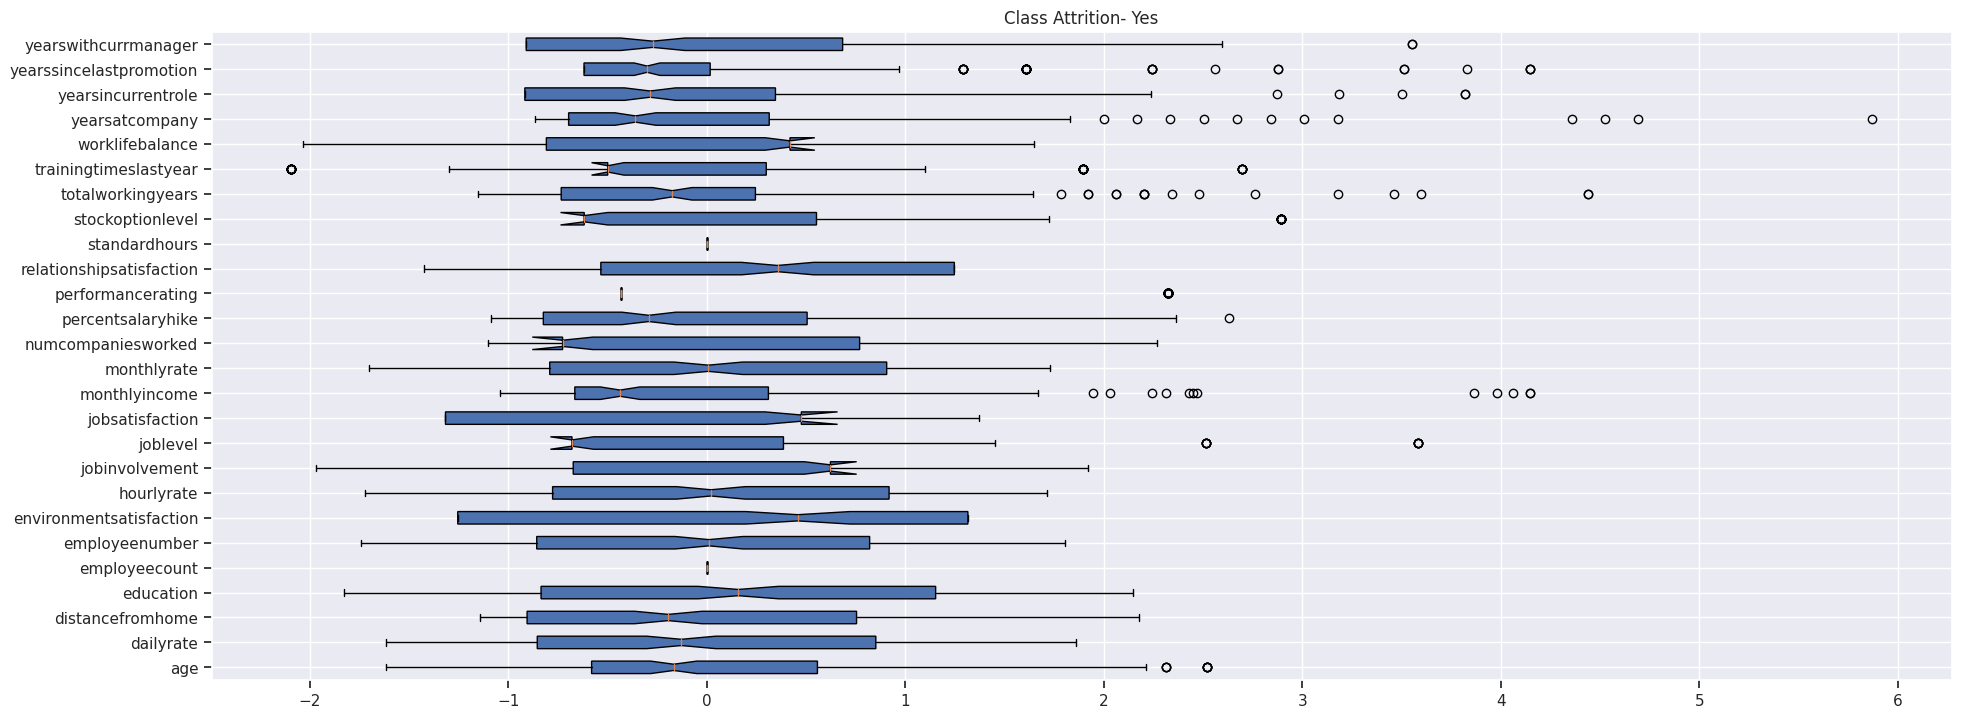

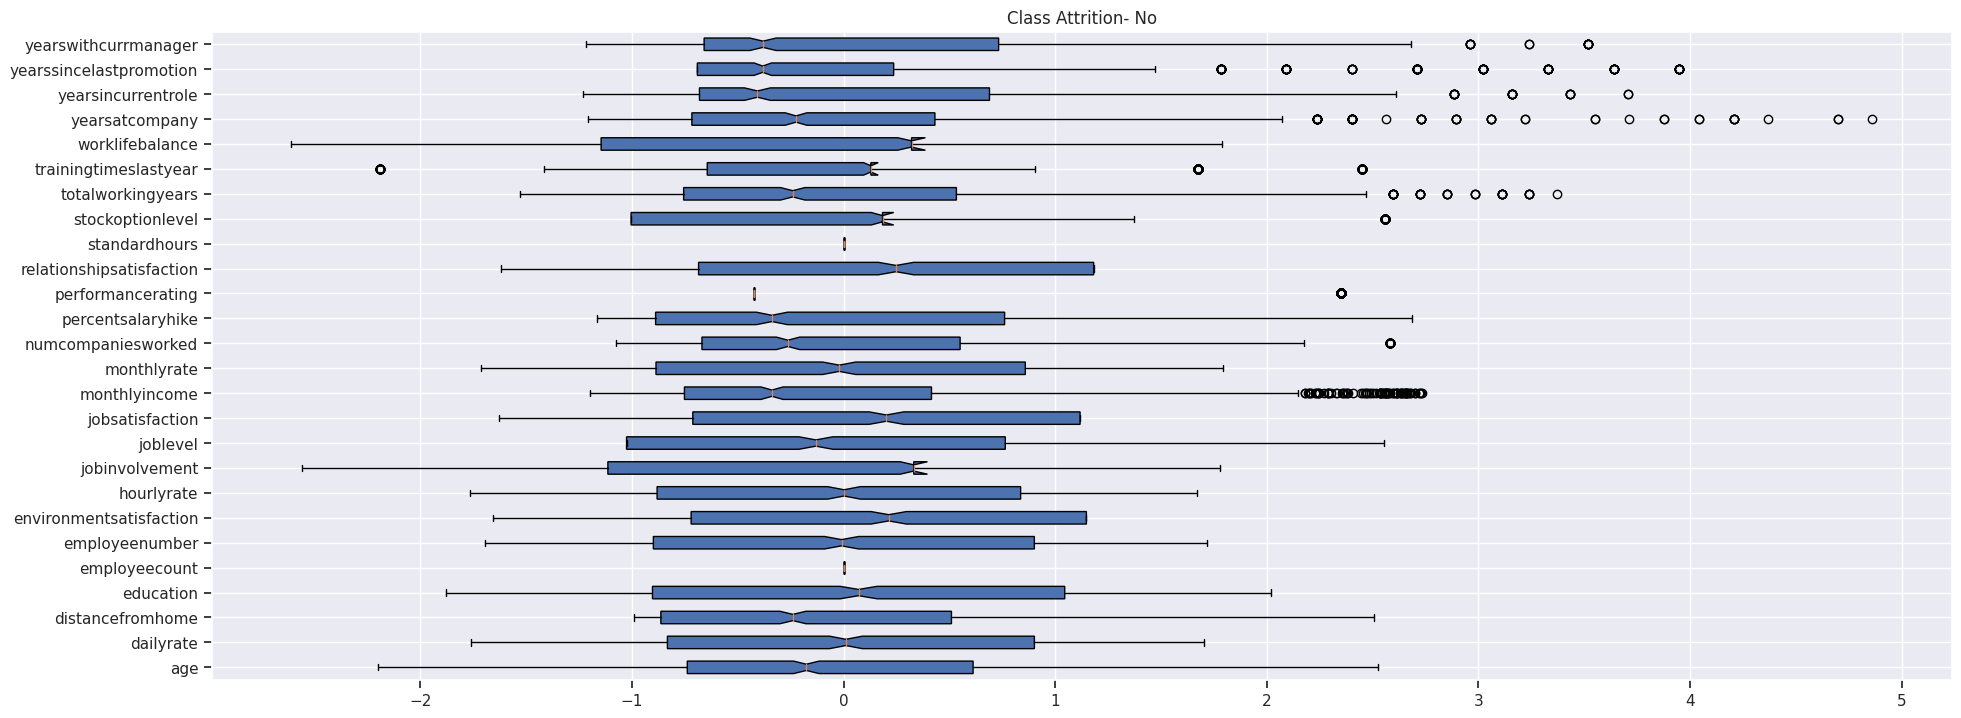

In [50]:
# Modify boxplots to show distributions against the target variable classes
# Apply standardization to plot on one graph
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
scale = StandardScaler()
ordinal = OrdinalEncoder()
data['attrition'] = ordinal.fit_transform(data[['attrition']])
df_yes = data[data['attrition'] == 1]
df_no = data[data['attrition'] == 0]
df_yes_numeric = df_yes.select_dtypes(include = 'number')
df_yes_numeric= df_yes_numeric.drop('attrition', axis = 1)
df_yes_numscaled = scale.fit_transform(df_yes_numeric)
df_no_numeric = df_no.select_dtypes(include = 'number')
df_no_numeric= df_no_numeric.drop('attrition', axis = 1)
df_no_numscaled = scale.fit_transform(df_no_numeric)

#Box Plot Version 1
figure1 = plt.figure(figsize =(20, 8))
figure2 = plt.figure(figsize =(20, 8))

ax1 = figure1.add_subplot(111)
ax2 = figure2.add_subplot(111)

bp1 = ax1.boxplot(df_yes_numscaled, patch_artist = True,notch ='True', vert = 0)
bp2 = ax2.boxplot(df_no_numscaled, patch_artist = True,notch ='True', vert = 0)

ax1.set_yticklabels(num_cols)
ax1.get_xaxis().tick_bottom()
ax1.get_yaxis().tick_left()
ax1.set_title('Class Attrition- Yes')
ax2.set_title('Class Attrition- No')
ax2.set_yticklabels(num_cols)
ax2.get_xaxis().tick_bottom()
ax2.get_yaxis().tick_left()

plt.show()

<Axes: xlabel='attrition', ylabel='worklifebalance'>

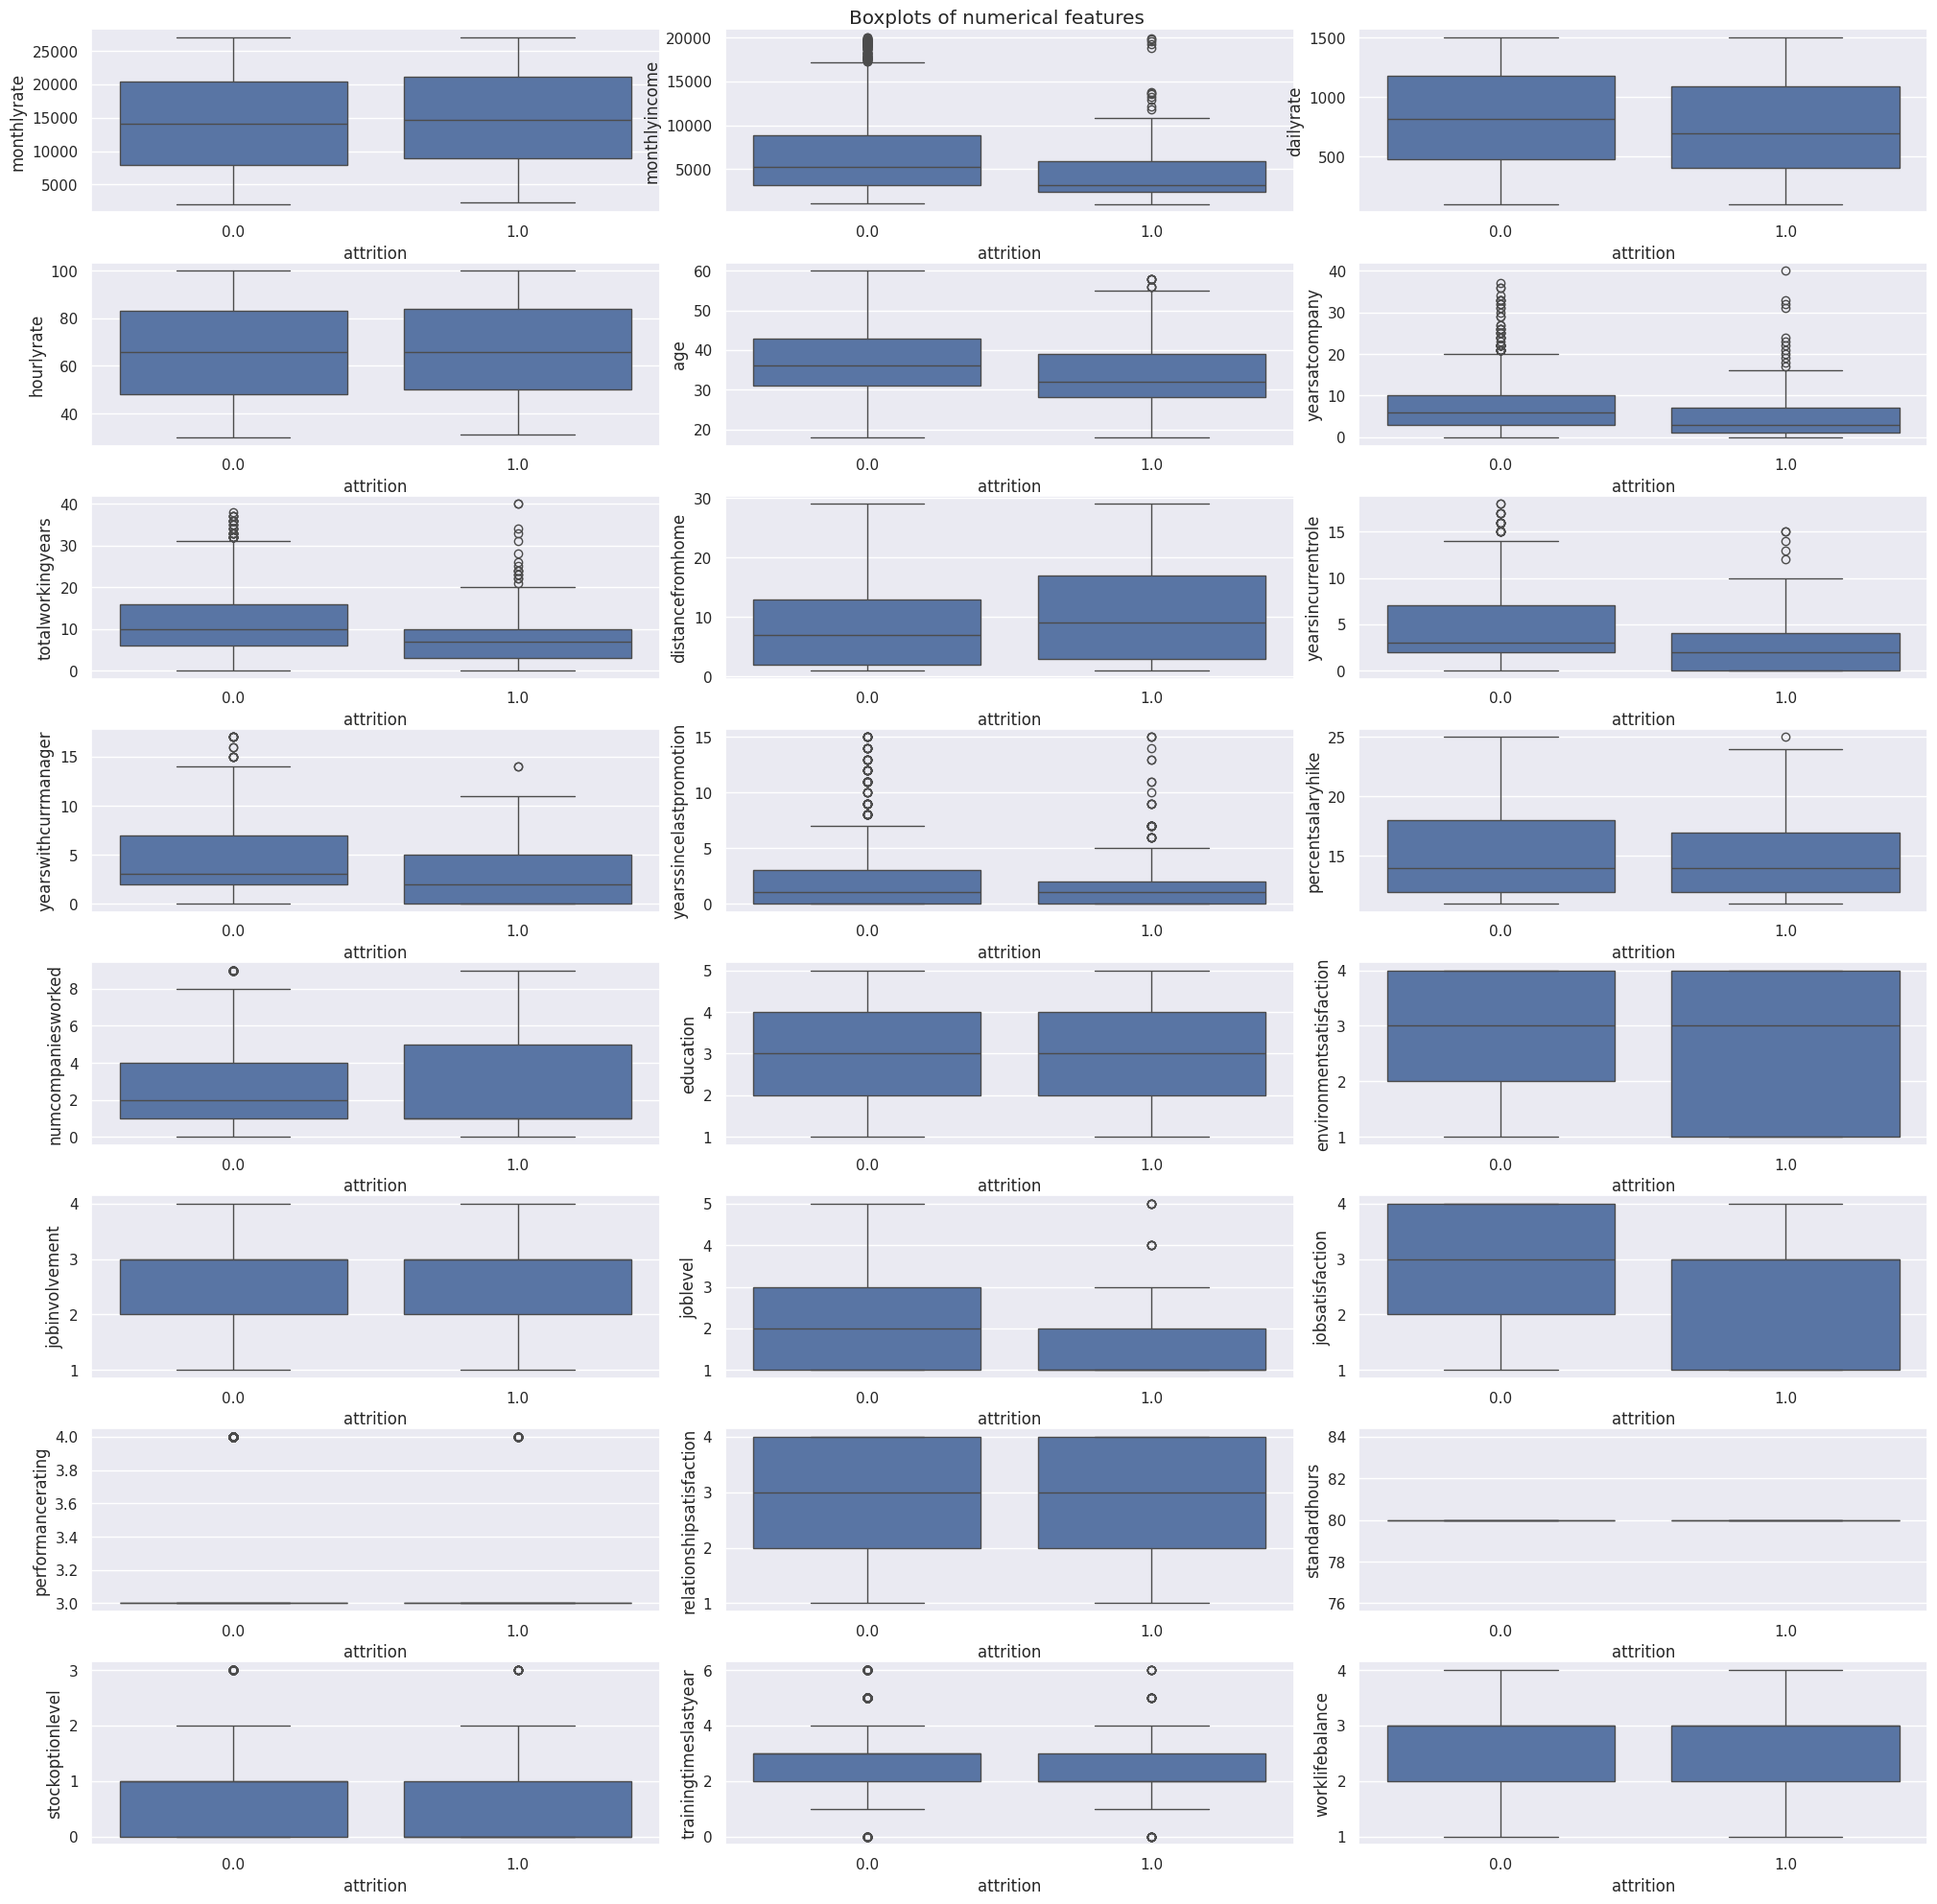

In [51]:
fig, axes = plt.subplots(8,3,figsize=(20,20))
fig.suptitle('Boxplots of numerical features')
fig.tight_layout()
sns.set()


#Row 1
sns.boxplot(ax=axes[0, 0], data=data, x='attrition', y='monthlyrate')
sns.boxplot(ax=axes[0, 1], data=data, x='attrition', y='monthlyincome')
sns.boxplot(ax=axes[0, 2], data=data, x='attrition', y='dailyrate')


#Row 2
sns.boxplot(ax=axes[1, 0], data=data, x='attrition', y='hourlyrate')
sns.boxplot(ax=axes[1, 1], data=data, x='attrition', y='age')
sns.boxplot(ax=axes[1, 2], data=data, x='attrition', y='yearsatcompany')

#Row 3
sns.boxplot(ax=axes[2, 0], data=data, x='attrition',y='totalworkingyears')
sns.boxplot(ax=axes[2, 1], data=data, x='attrition',y='distancefromhome')
sns.boxplot(ax=axes[2, 2], data=data, x='attrition',y='yearsincurrentrole')

#Row 4
sns.boxplot(ax=axes[3, 0], data=data, x='attrition',y='yearswithcurrmanager')
sns.boxplot(ax=axes[3, 1], data=data, x='attrition',y='yearssincelastpromotion')
sns.boxplot(ax=axes[3, 2], data=data, x='attrition',y='percentsalaryhike')

#Row 5
sns.boxplot(ax=axes[4, 0], data=data, x='attrition',y='numcompaniesworked')
sns.boxplot(ax=axes[4, 1], data=data, x='attrition',y='education')
sns.boxplot(ax=axes[4, 2], data=data, x='attrition',y='environmentsatisfaction')


#Row 6
sns.boxplot(ax=axes[5, 0], data=data, x='attrition',y='jobinvolvement')
sns.boxplot(ax=axes[5, 1], data=data, x='attrition',y='joblevel')
sns.boxplot(ax=axes[5, 2], data=data, x='attrition',y='jobsatisfaction')


#Row 7
sns.boxplot(ax=axes[6, 0], data=data, x='attrition',y='performancerating')
sns.boxplot(ax=axes[6, 1], data=data, x='attrition',y='relationshipsatisfaction')
sns.boxplot(ax=axes[6, 2], data=data, x='attrition',y='standardhours')


#Row 8
sns.boxplot(ax=axes[7, 0], data=data, x='attrition',y='stockoptionlevel')
sns.boxplot(ax=axes[7, 1], data=data, x='attrition',y='trainingtimeslastyear')
sns.boxplot(ax=axes[7, 2], data=data, x='attrition',y='worklifebalance')


<Axes: xlabel='jobsatisfaction', ylabel='Count'>

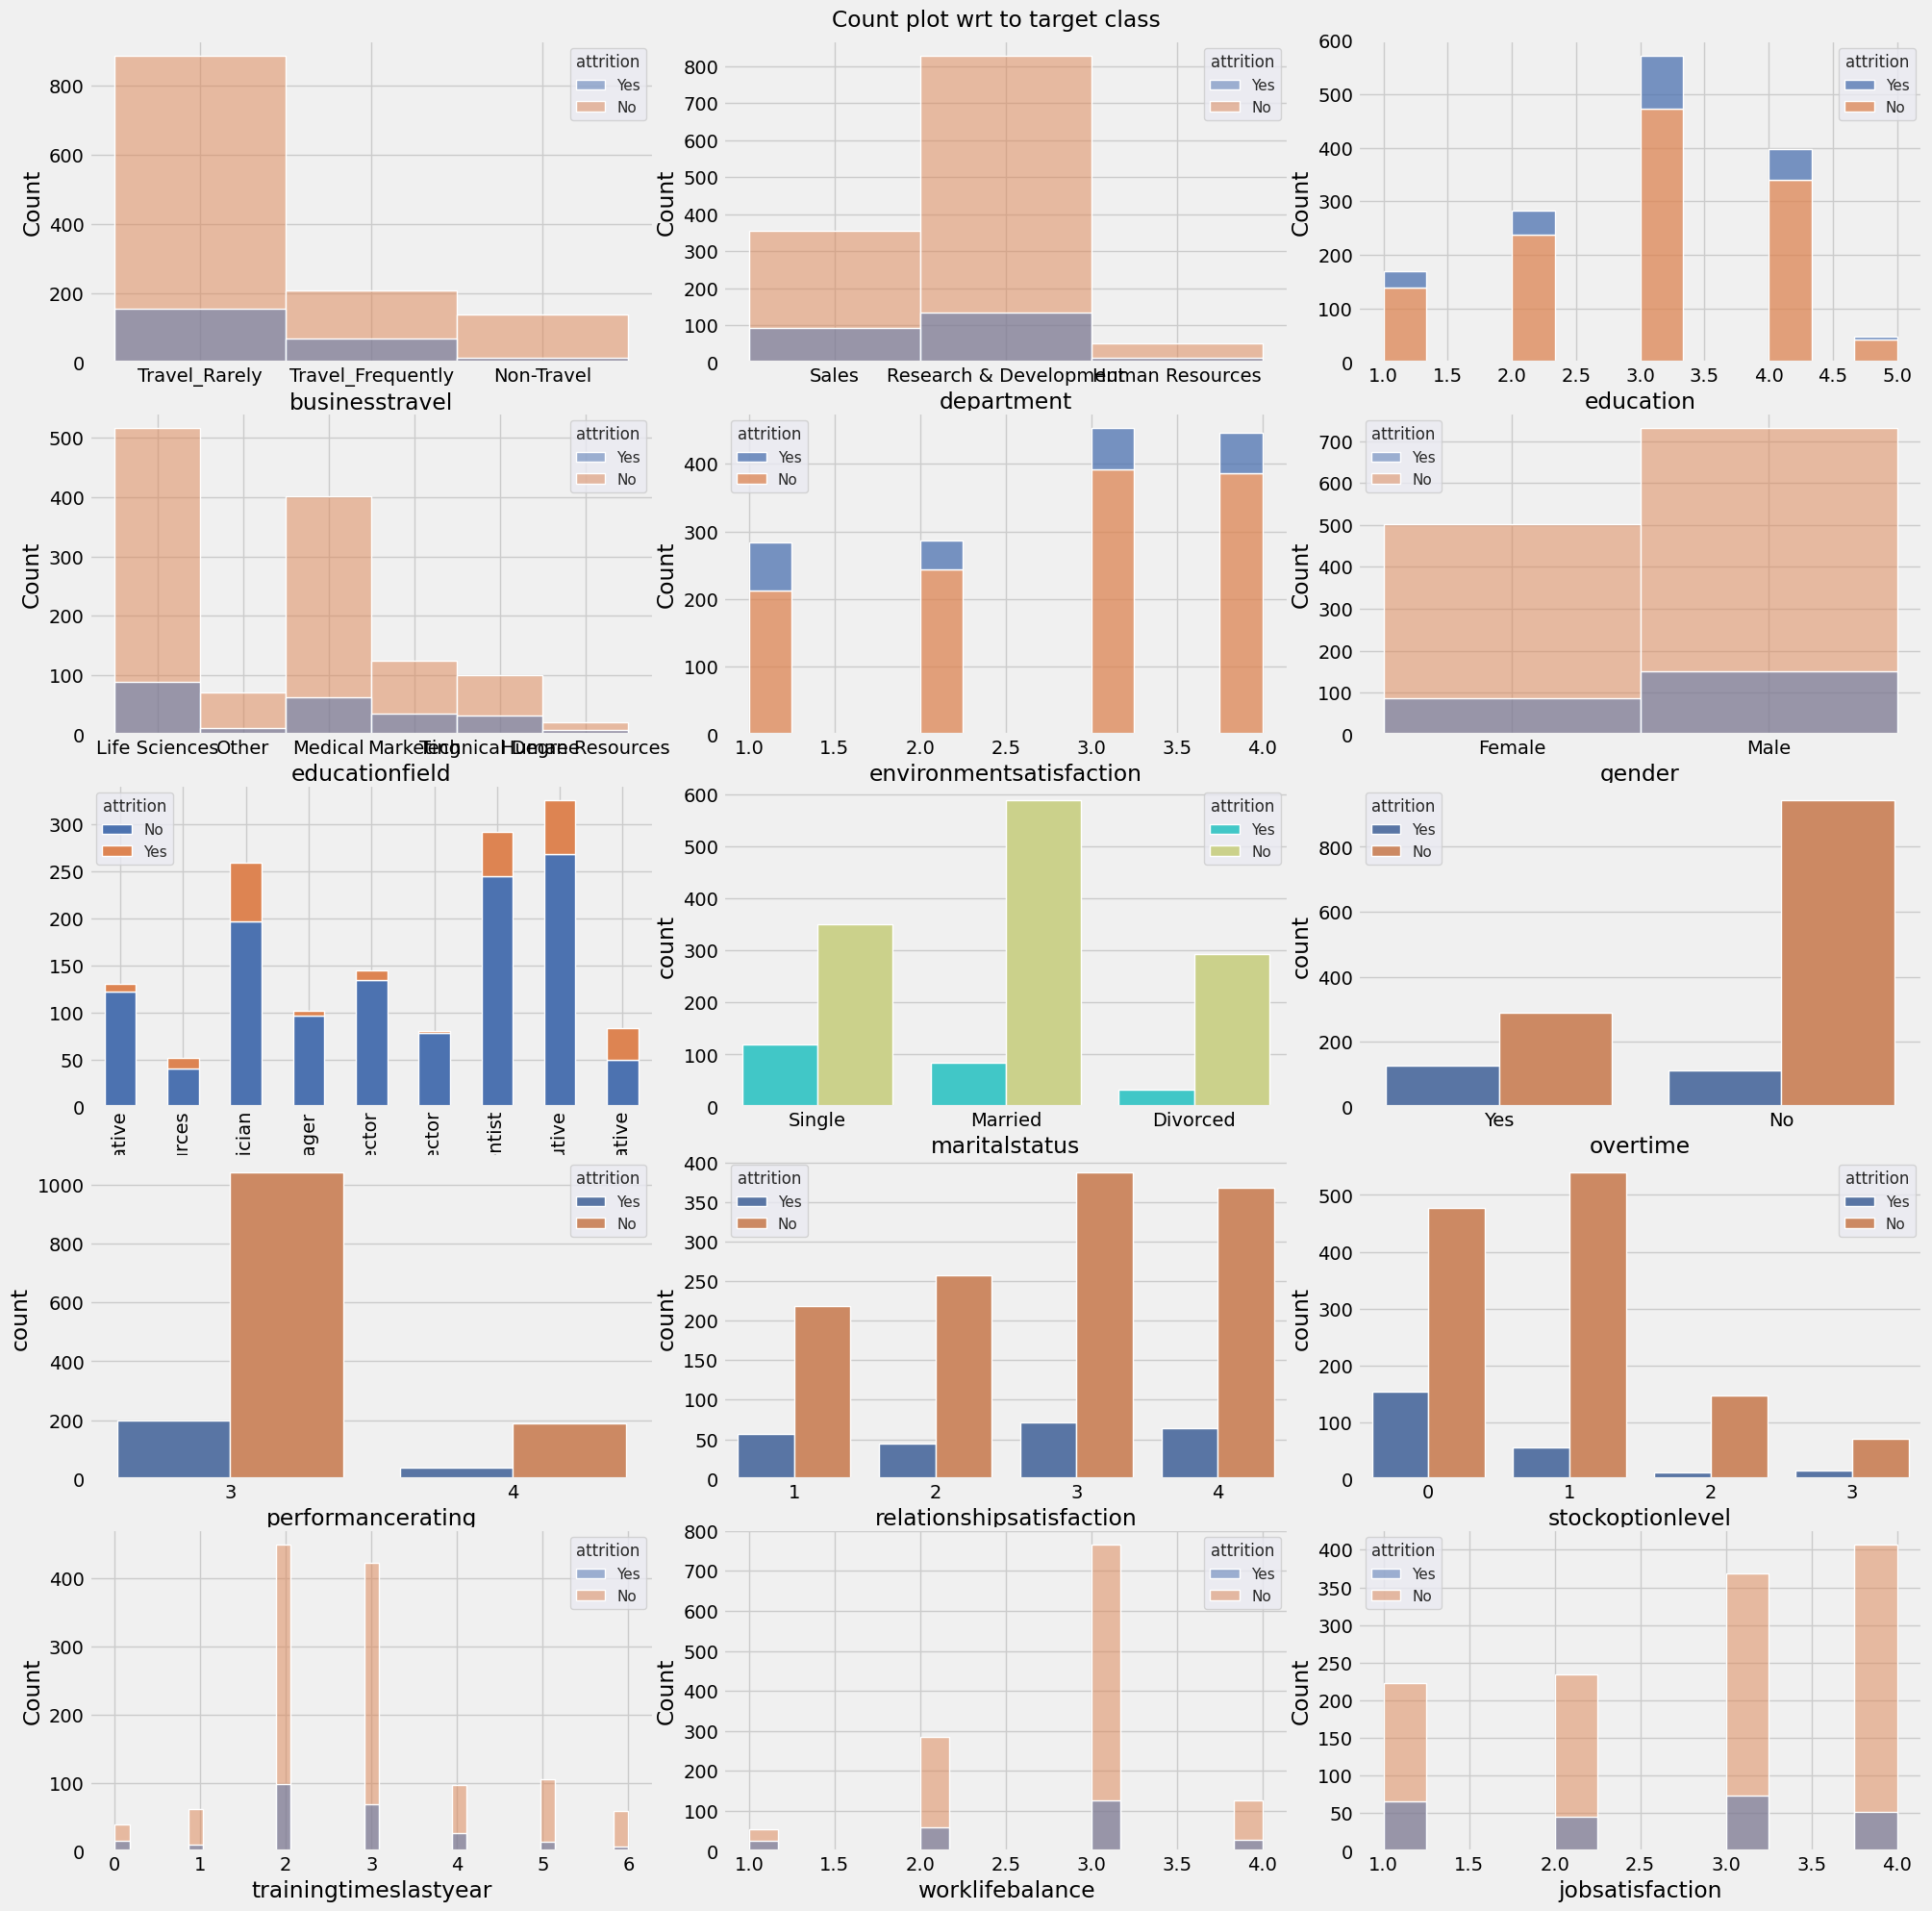

In [8]:
# Count plot
fig, axes = plt.subplots(5,3,figsize=(20,20))
fig.suptitle('Count plot wrt to target class')
fig.tight_layout()
sns.set()

sns.histplot(ax=axes[0, 0], data=data, x="businesstravel", hue="attrition")
sns.histplot(ax=axes[0, 1], x = 'department', hue = 'attrition', data = data)
sns.histplot(ax=axes[0, 2], x = "education", hue = "attrition", data = data, multiple="stack")

sns.histplot(ax=axes[1, 0], x="educationfield", hue="attrition", data=data)
sns.histplot(ax=axes[1, 1], data=data, x="environmentsatisfaction", hue="attrition", multiple="stack")
sns.histplot(ax=axes[1, 2], data=data, x="gender", hue="attrition")

data.groupby(['jobrole','attrition'])['attrition'].count().unstack().plot(kind='bar', stacked=True, ax=axes[2, 0])
sns.countplot(ax=axes[2, 1], x='maritalstatus',hue='attrition',data=data,palette='rainbow')
sns.countplot(ax=axes[2, 2], x='overtime', hue='attrition', data=data)

sns.countplot(ax=axes[3, 0], x = 'performancerating', hue = 'attrition', data = data)
sns.countplot(ax=axes[3, 1], x='relationshipsatisfaction', hue='attrition', data=data)
sns.countplot(ax=axes[3, 2], x='stockoptionlevel', hue='attrition', data=data)

sns.histplot(ax=axes[4, 0], x = 'trainingtimeslastyear', hue = 'attrition', data = data)
sns.histplot(ax=axes[4, 1], x='worklifebalance', hue='attrition', data=data)
sns.histplot(ax=axes[4, 2], x="jobsatisfaction", hue="attrition", data=data)


### Handling outliers

**Exercise 4: Use lower bound as 25% and upper bound as 75% to handle the outliers [0.5 Mark]**

In [38]:
# YOUR CODE HERE
# creating a copy of original dataframe
df1 = data.copy()

# 1. dropping the columns which is having single value
drop_col = ['employeecount', 'over18','standardhours']
df1.drop(drop_col, axis=1, inplace=True)

# 2. Capping the data i.e. replacing the outliers using 5th and 95th percentile
cap_col = ['dailyrate','monthlyrate','percentsalaryhike','totalworkingyears','trainingtimeslastyear','yearsatcompany','yearsincurrentrole','yearssincelastpromotion','yearswithcurrmanager']
for i in cap_col:
  Q1 = np.percentile(df1[i], 25)
  Q3 = np.percentile(df1[i], 75)
  iqr = Q3 - Q1
  lower_limit = Q1 - 1.5*iqr
  upper_limit = Q3 + 1.5*iqr
  df1[i] = np.where(df1[i]<Q1, Q1, np.where(df1[i]>Q3, Q3, df1[i]))

# 3. Binning the categorical columns i.e. age
low_lm = df1['age'].min()
upp_lm = df1['age'].max()

bins = np.arange(low_lm, upp_lm+5, 5)

df1['age'] = pd.cut(df1['age'], bins, labels=['1','2','3','4','5','6','7','8','9'], include_lowest=True)


# 4. Capping and binning of monthlyincome column
  #Capping
Q_1 = np.percentile(df1['monthlyincome'], 25)
Q_3 = np.percentile(df1['monthlyincome'], 75)
iqr = Q_3 - Q_1

income_lower_limit= Q_1 - 1.5*iqr
income_upper_limit = Q_3 + 1.5*iqr
df1['monthlyinc_capping'] = np.where(df1['monthlyincome']<Q_1, Q_1, np.where(df1['monthlyincome']>Q_3, Q_3, df1['monthlyincome']))

  # Binning
income_low = df1['monthlyincome'].min()
income_upp = df1['monthlyincome'].max()

bins_income = np.arange(income_low, income_upp+2000, 2000)

df1['monthlyinc_binning'] = pd.cut(df1['monthlyincome'], bins_income, labels=['1','2','3','4','5','6','7','8','9','10'], include_lowest=True)

<Axes: xlabel='attrition', ylabel='worklifebalance'>

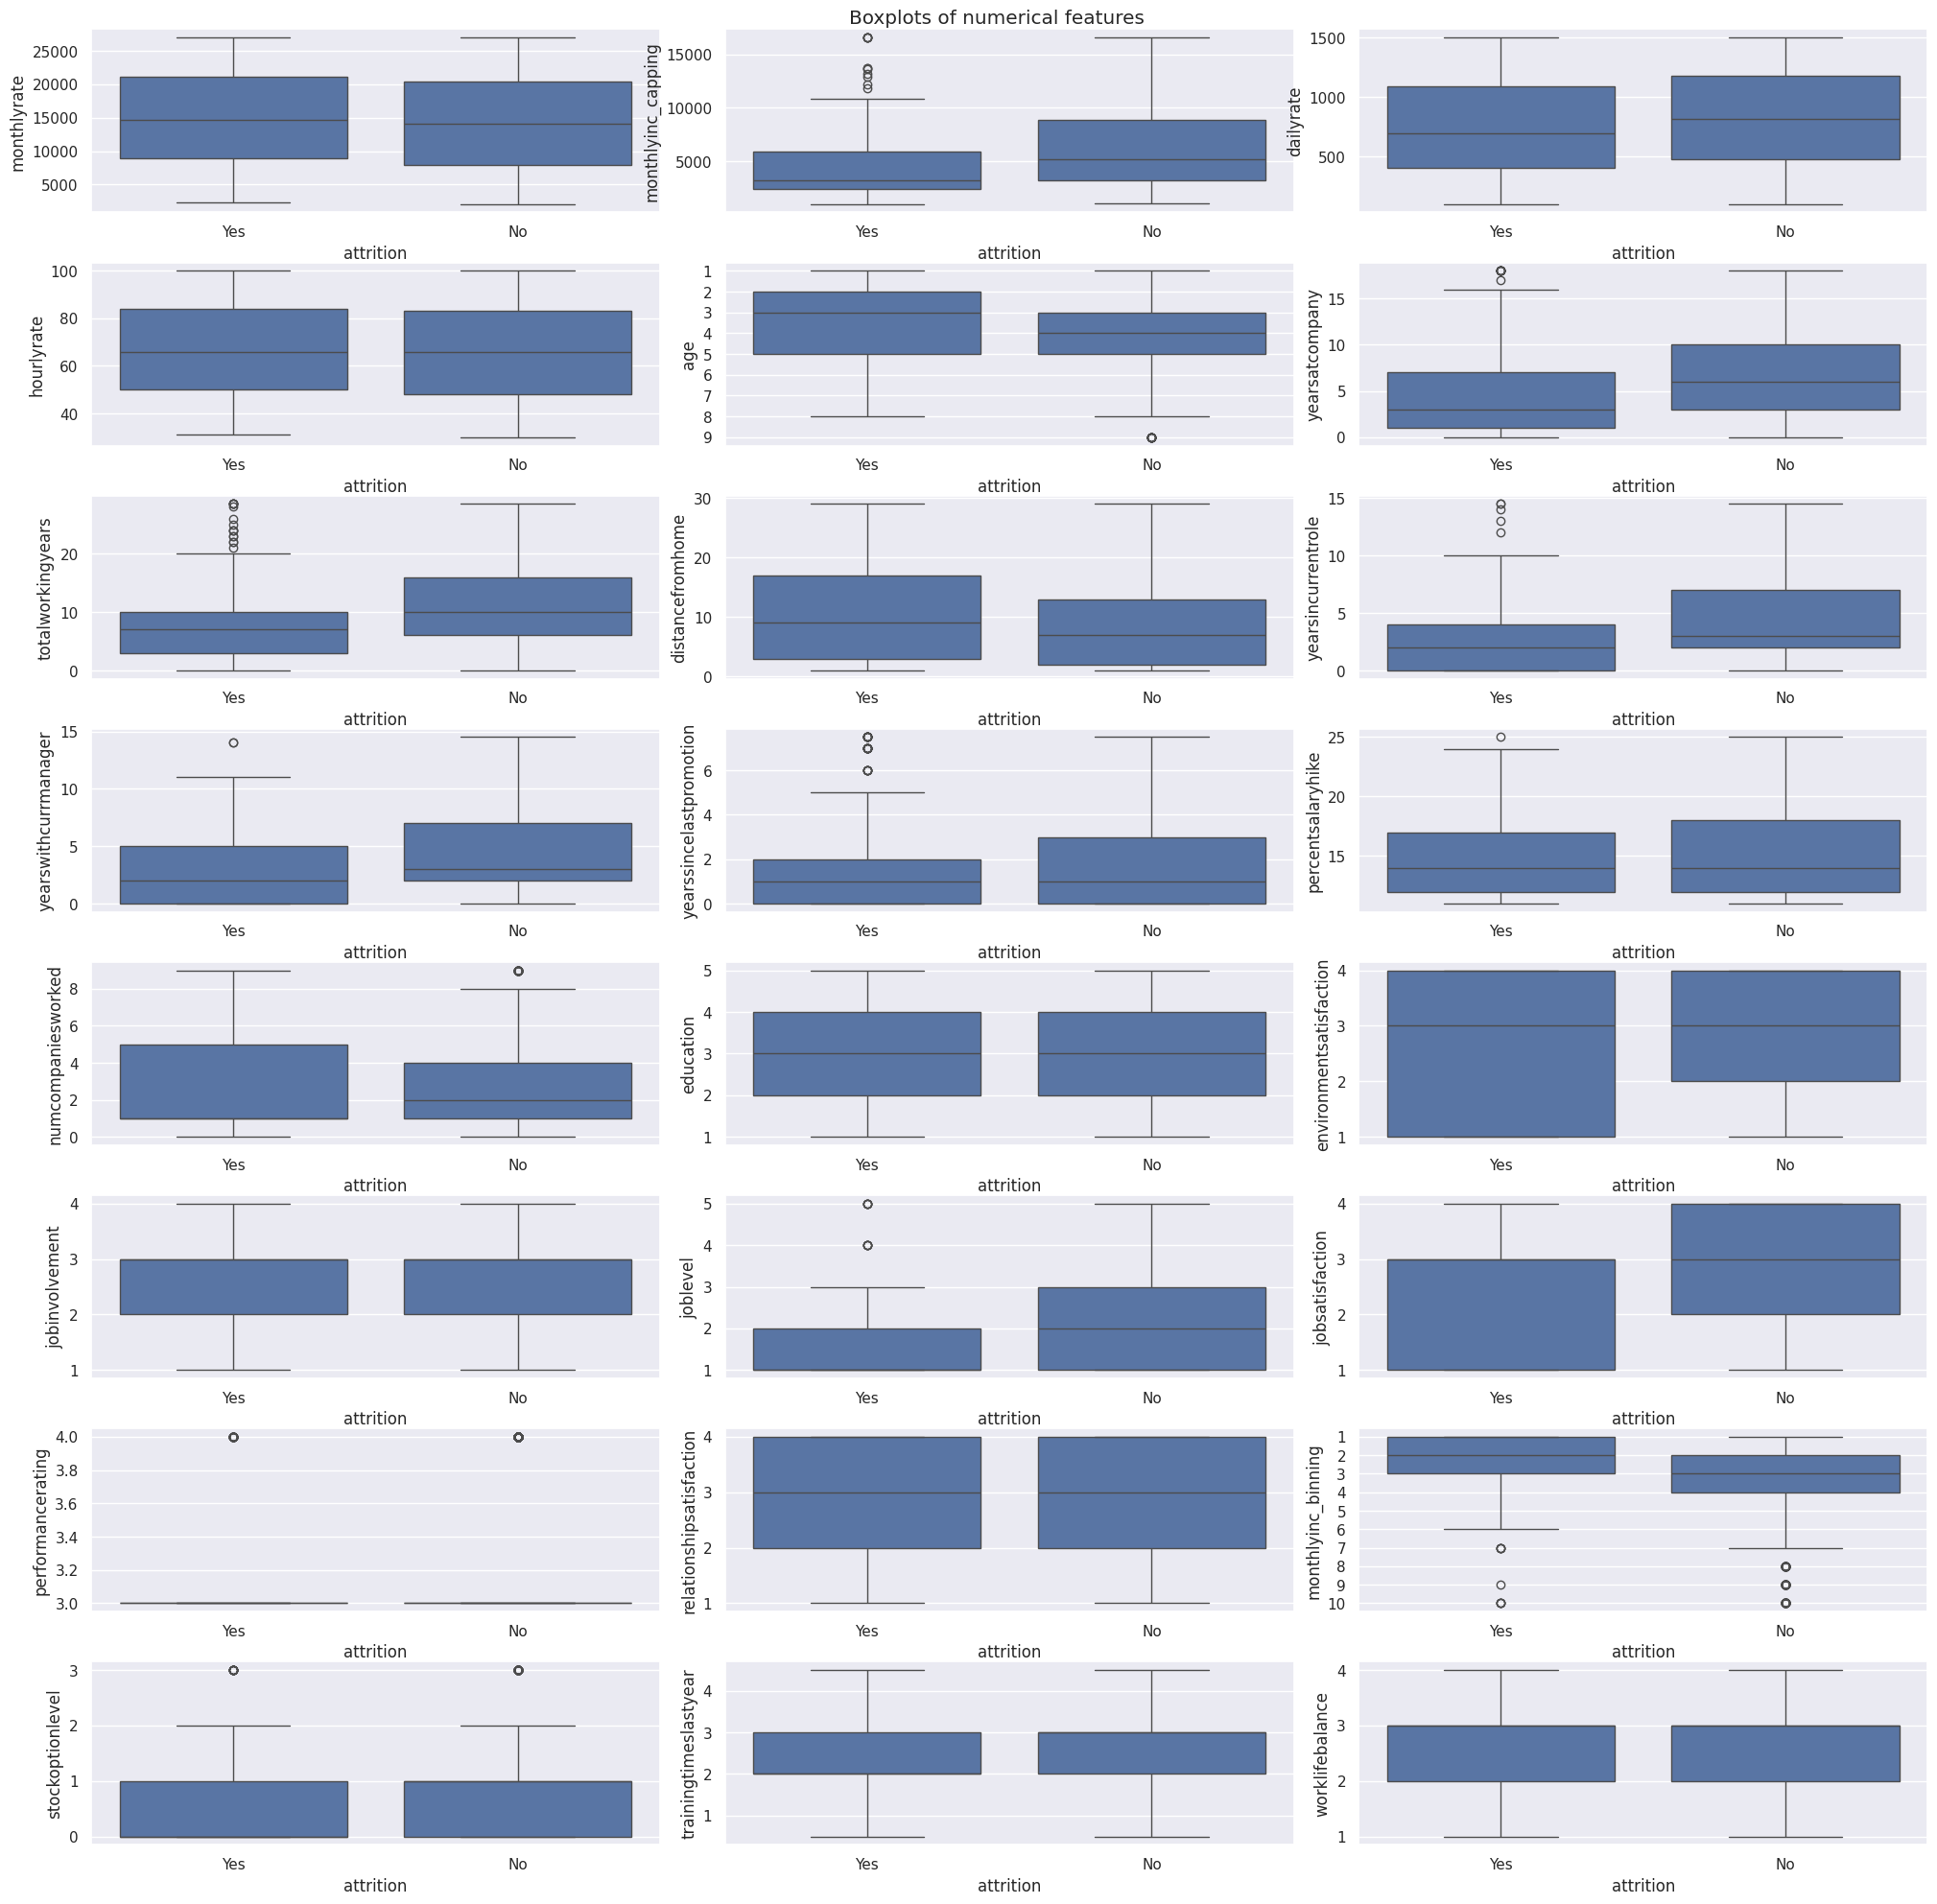

In [10]:
# Recheck for outliers
## Plotting the outlier treated data
fig, axes = plt.subplots(8,3,figsize=(20,20))
fig.suptitle('Boxplots of numerical features')
fig.tight_layout()
sns.set()


#Row 1
sns.boxplot(ax=axes[0, 0], data=df1, x='attrition', y='monthlyrate')
sns.boxplot(ax=axes[0, 1], data=df1, x='attrition', y='monthlyinc_capping')
sns.boxplot(ax=axes[0, 2], data=df1, x='attrition', y='dailyrate')


#Row 2
sns.boxplot(ax=axes[1, 0], data=df1, x='attrition', y='hourlyrate')
sns.boxplot(ax=axes[1, 1], data=df1, x='attrition', y='age')
sns.boxplot(ax=axes[1, 2], data=df1, x='attrition', y='yearsatcompany')

#Row 3
sns.boxplot(ax=axes[2, 0], data=df1, x='attrition',y='totalworkingyears')
sns.boxplot(ax=axes[2, 1], data=df1, x='attrition',y='distancefromhome')
sns.boxplot(ax=axes[2, 2], data=df1, x='attrition',y='yearsincurrentrole')

#Row 4
sns.boxplot(ax=axes[3, 0], data=df1, x='attrition',y='yearswithcurrmanager')
sns.boxplot(ax=axes[3, 1], data=df1, x='attrition',y='yearssincelastpromotion')
sns.boxplot(ax=axes[3, 2], data=df1, x='attrition',y='percentsalaryhike')

#Row 5
sns.boxplot(ax=axes[4, 0], data=df1, x='attrition',y='numcompaniesworked')
sns.boxplot(ax=axes[4, 1], data=df1, x='attrition',y='education')
sns.boxplot(ax=axes[4, 2], data=df1, x='attrition',y='environmentsatisfaction')


#Row 6
sns.boxplot(ax=axes[5, 0], data=df1, x='attrition',y='jobinvolvement')
sns.boxplot(ax=axes[5, 1], data=df1, x='attrition',y='joblevel')
sns.boxplot(ax=axes[5, 2], data=df1, x='attrition',y='jobsatisfaction')


#Row 7
sns.boxplot(ax=axes[6, 0], data=df1, x='attrition',y='performancerating')
sns.boxplot(ax=axes[6, 1], data=df1, x='attrition',y='relationshipsatisfaction')
sns.boxplot(ax=axes[6, 2], data=df1, x='attrition',y='monthlyinc_binning')


#Row 8
sns.boxplot(ax=axes[7, 0], data=df1, x='attrition',y='stockoptionlevel')
sns.boxplot(ax=axes[7, 1], data=df1, x='attrition',y='trainingtimeslastyear')
sns.boxplot(ax=axes[7, 2], data=df1, x='attrition',y='worklifebalance')


In [11]:
## One hot encoding the categorical data
# Method-1
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse_output=False,drop= 'first')
one_hot_encod_col = ['attrition','businesstravel','department','educationfield','gender','jobrole','maritalstatus','overtime']

one_hot_encoded = encoder.fit_transform(df1[one_hot_encod_col])

one_hot_df = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(one_hot_encod_col))
one_hot_df
df_encoded = pd.concat([df1, one_hot_df], axis=1)
df_encoded = df_encoded.drop(one_hot_encod_col, axis=1)
print(df_encoded.shape)

# Method-2
df_encoded_2 = pd.get_dummies(df1, columns=one_hot_encod_col, sparse=False,drop_first=True)
print(df_encoded_2.shape)

(1470, 48)
(1470, 48)


In [12]:
df_encoded['age'] = df_encoded['age'].astype('float')
df_encoded['monthlyinc_binning'] = df_encoded['monthlyinc_binning'].astype('float')
# df_encoded.info()
df_final = df_encoded.drop('monthlyincome', axis=1)

In [13]:
df_final.head()

age  dailyrate  distancefromhome  education  employeenumber  \
0  5.0     1102.0                 1          2               1   
1  7.0      279.0                 8          1               2   
2  4.0     1373.0                 2          2               4   
3  3.0     1392.0                 3          4               5   
4  2.0      591.0                 2          1               7   

   environmentsatisfaction  hourlyrate  jobinvolvement  joblevel  \
0                        2          94               3         2   
1                        3          61               2         2   
2                        4          92               2         1   
3                        4          56               3         1   
4                        1          40               3         1   

   jobsatisfaction  monthlyrate  numcompaniesworked  percentsalaryhike  \
0                4      19479.0                   8               11.0   
1                2      24907.0                   1               23.0   
2                3       2396.0                   6               15.0   
3                3      23159.0                   1               11.0   
4                2      16632.0                   9               12.0   

   performancerating  relationshipsatisfaction  stockoptionlevel  \
0                  3                         1                 0   
1                  4                         4                 1   
2                  3                         2                 0   
3                  3                         3                 0   
4                  3                         4                 1   

   totalworkingyears  trainingtimeslastyear  worklifebalance  yearsatcompany  \
0                8.0                    0.5                1             6.0   
1               10.0                    3.0                3            10.0   
2                7.0                    3.0                3             0.0   
3                8.0                    3.0                3             8.0   
4                6.0                    3.0                3             2.0   

   yearsincurrentrole  yearssincelastpromotion  yearswithcurrmanager  \
0                 4.0                      0.0                   5.0   
1                 7.0                      1.0                   7.0   
2                 0.0                      0.0                   0.0   
3                 7.0                      3.0                   0.0   
4                 2.0                      2.0                   2.0   

   monthlyinc_capping  monthlyinc_binning  attrition_Yes  \
0              5993.0                 3.0            1.0   
1              5130.0                 3.0            0.0   
2              2090.0                 1.0            1.0   
3              2909.0                 1.0            0.0   
4              3468.0                 2.0            0.0   

   businesstravel_Travel_Frequently  businesstravel_Travel_Rarely  \
0                               0.0                           1.0   
1                               1.0                           0.0   
2                               0.0                           1.0   
3                               1.0                           0.0   
4                               0.0                           1.0   

   department_Research & Development  department_Sales  \
0                                0.0               1.0   
1                                1.0               0.0   
2                                1.0               0.0   
3                                1.0               0.0   
4                                1.0               0.0   

   educationfield_Life Sciences  educationfield_Marketing  \
0                           1.0                       0.0   
1                           1.0                       0.0   
2                           0.0                       0.0   
3                           1.0                       0.0   

### Target label imbalance

**Exercise 5: Check if there is an imbalance in target label [0.5 Mark]**

**Hint:** Use value_counts()

In [54]:
# Count of unique values in Attrition column
df1['attrition'].value_counts()

attrition
No     1233
Yes     237
Name: count, dtype: int64

<Axes: xlabel='attrition', ylabel='count'>

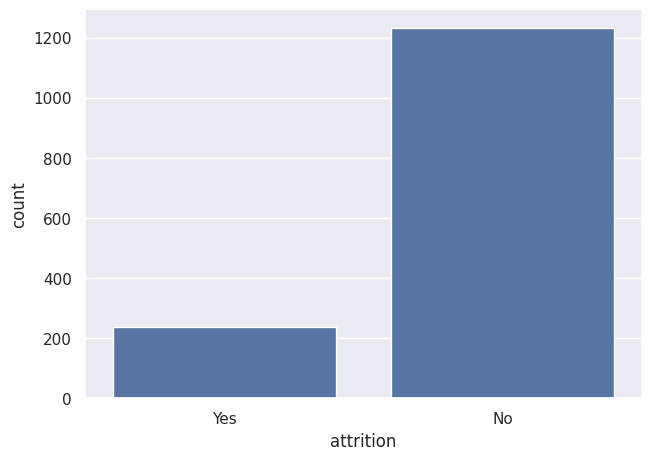

In [55]:
# Plot barplot to visualize balance/imbalance
# YOUR CODE HERE
sns.countplot(data=df1, x='attrition')

If there is any imbalance in the dataset then a few techniques can be utilised (optional):
1. SMOTE
2. Cross Validation
3. Regularizing the model's parameters

###Plot pairplot

**Exercise 6: Visualize the relationships between the predictor variables and the target variable using a pairplot [0.5 Mark]**

**Hint:** Use sns.pairplot

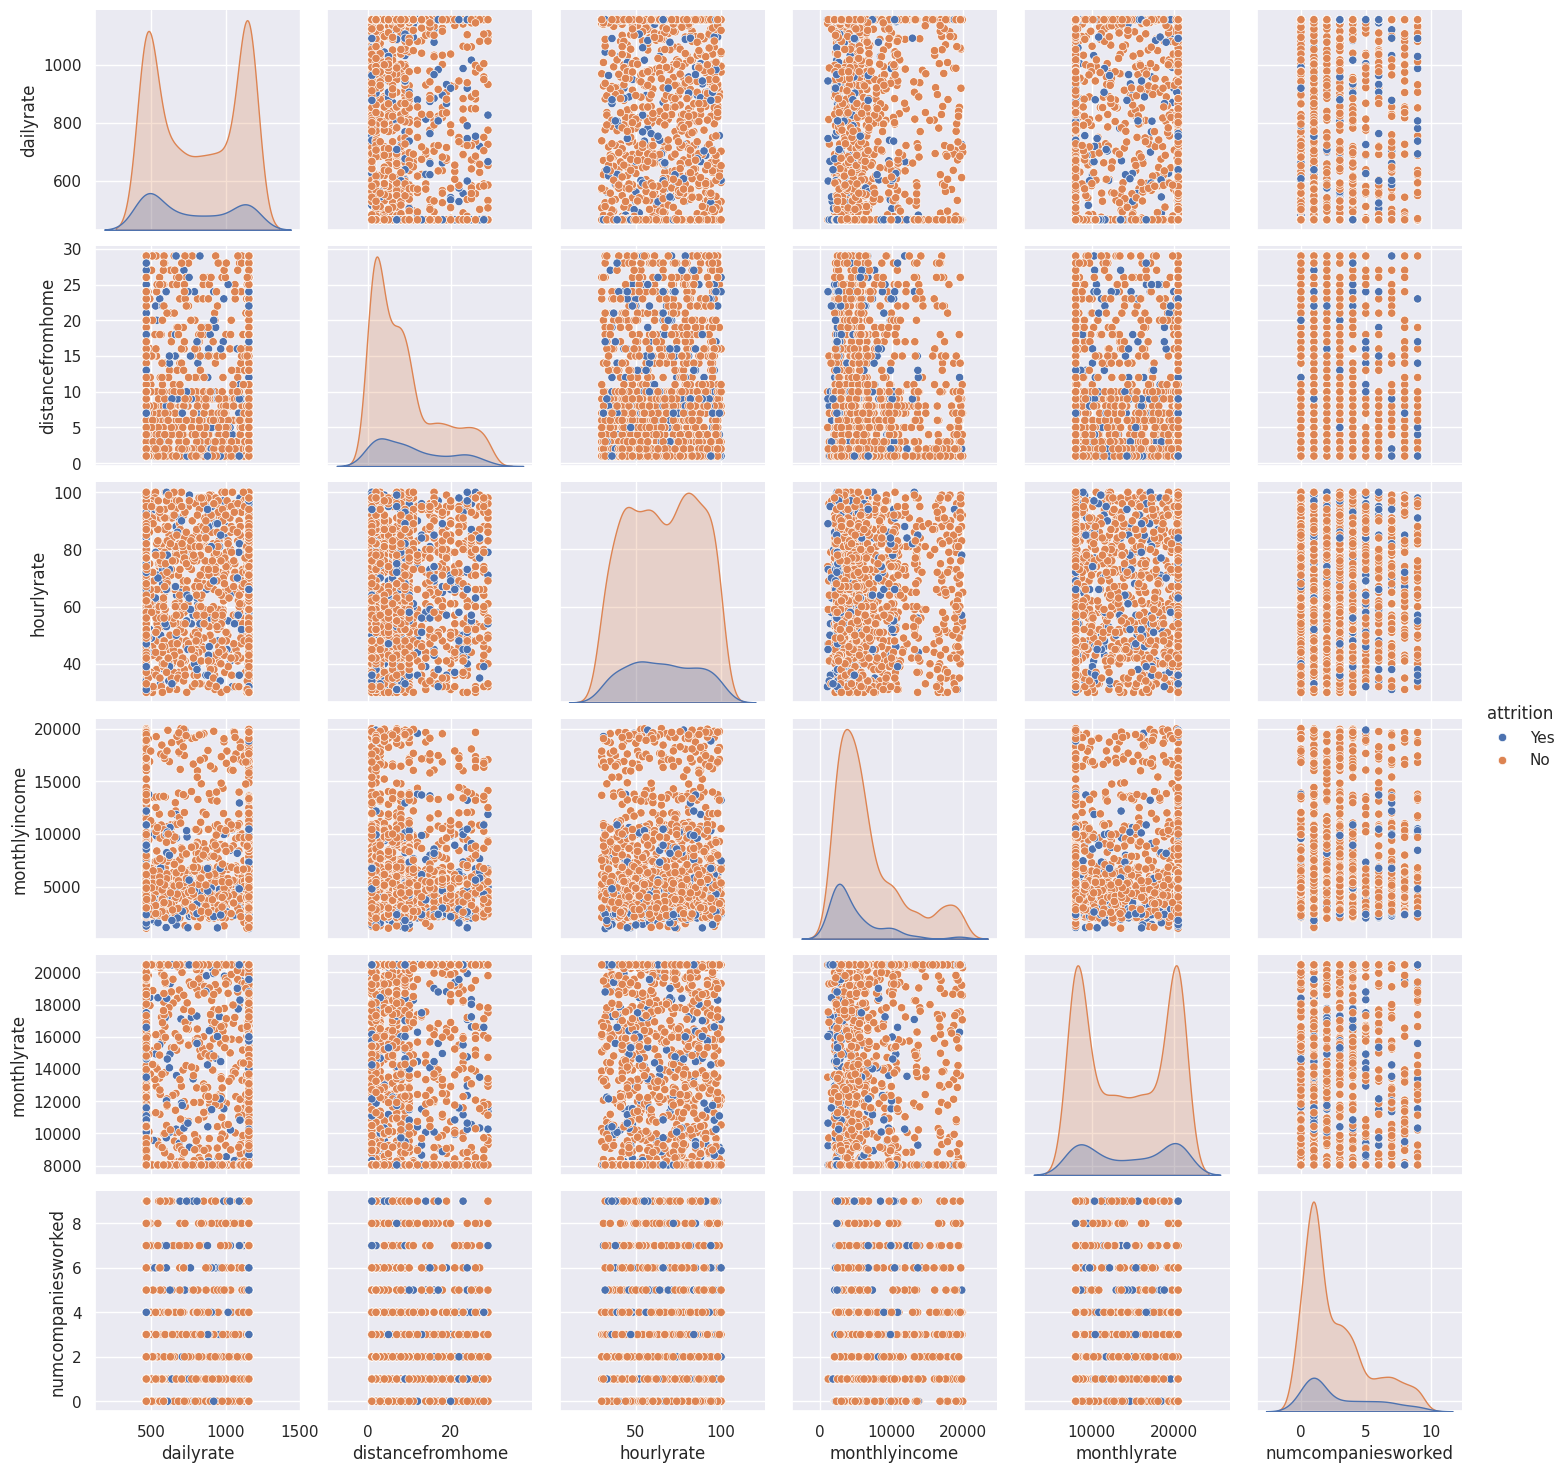

In [56]:
# Visualize a pairplot with relevant features
# YOUR CODE HERE
sns.set_context(font_scale=0.75, rc={"figure.figsize": (20, 20)})
subset = ['age','dailyrate',
 'distancefromhome',
 'hourlyrate',
 'monthlyincome',
 'monthlyrate', 'numcompaniesworked']

df_pairplot = pd.concat([df1[subset], df1['attrition']], axis=1)
sns.pairplot(df_pairplot, hue="attrition", height=2.5)



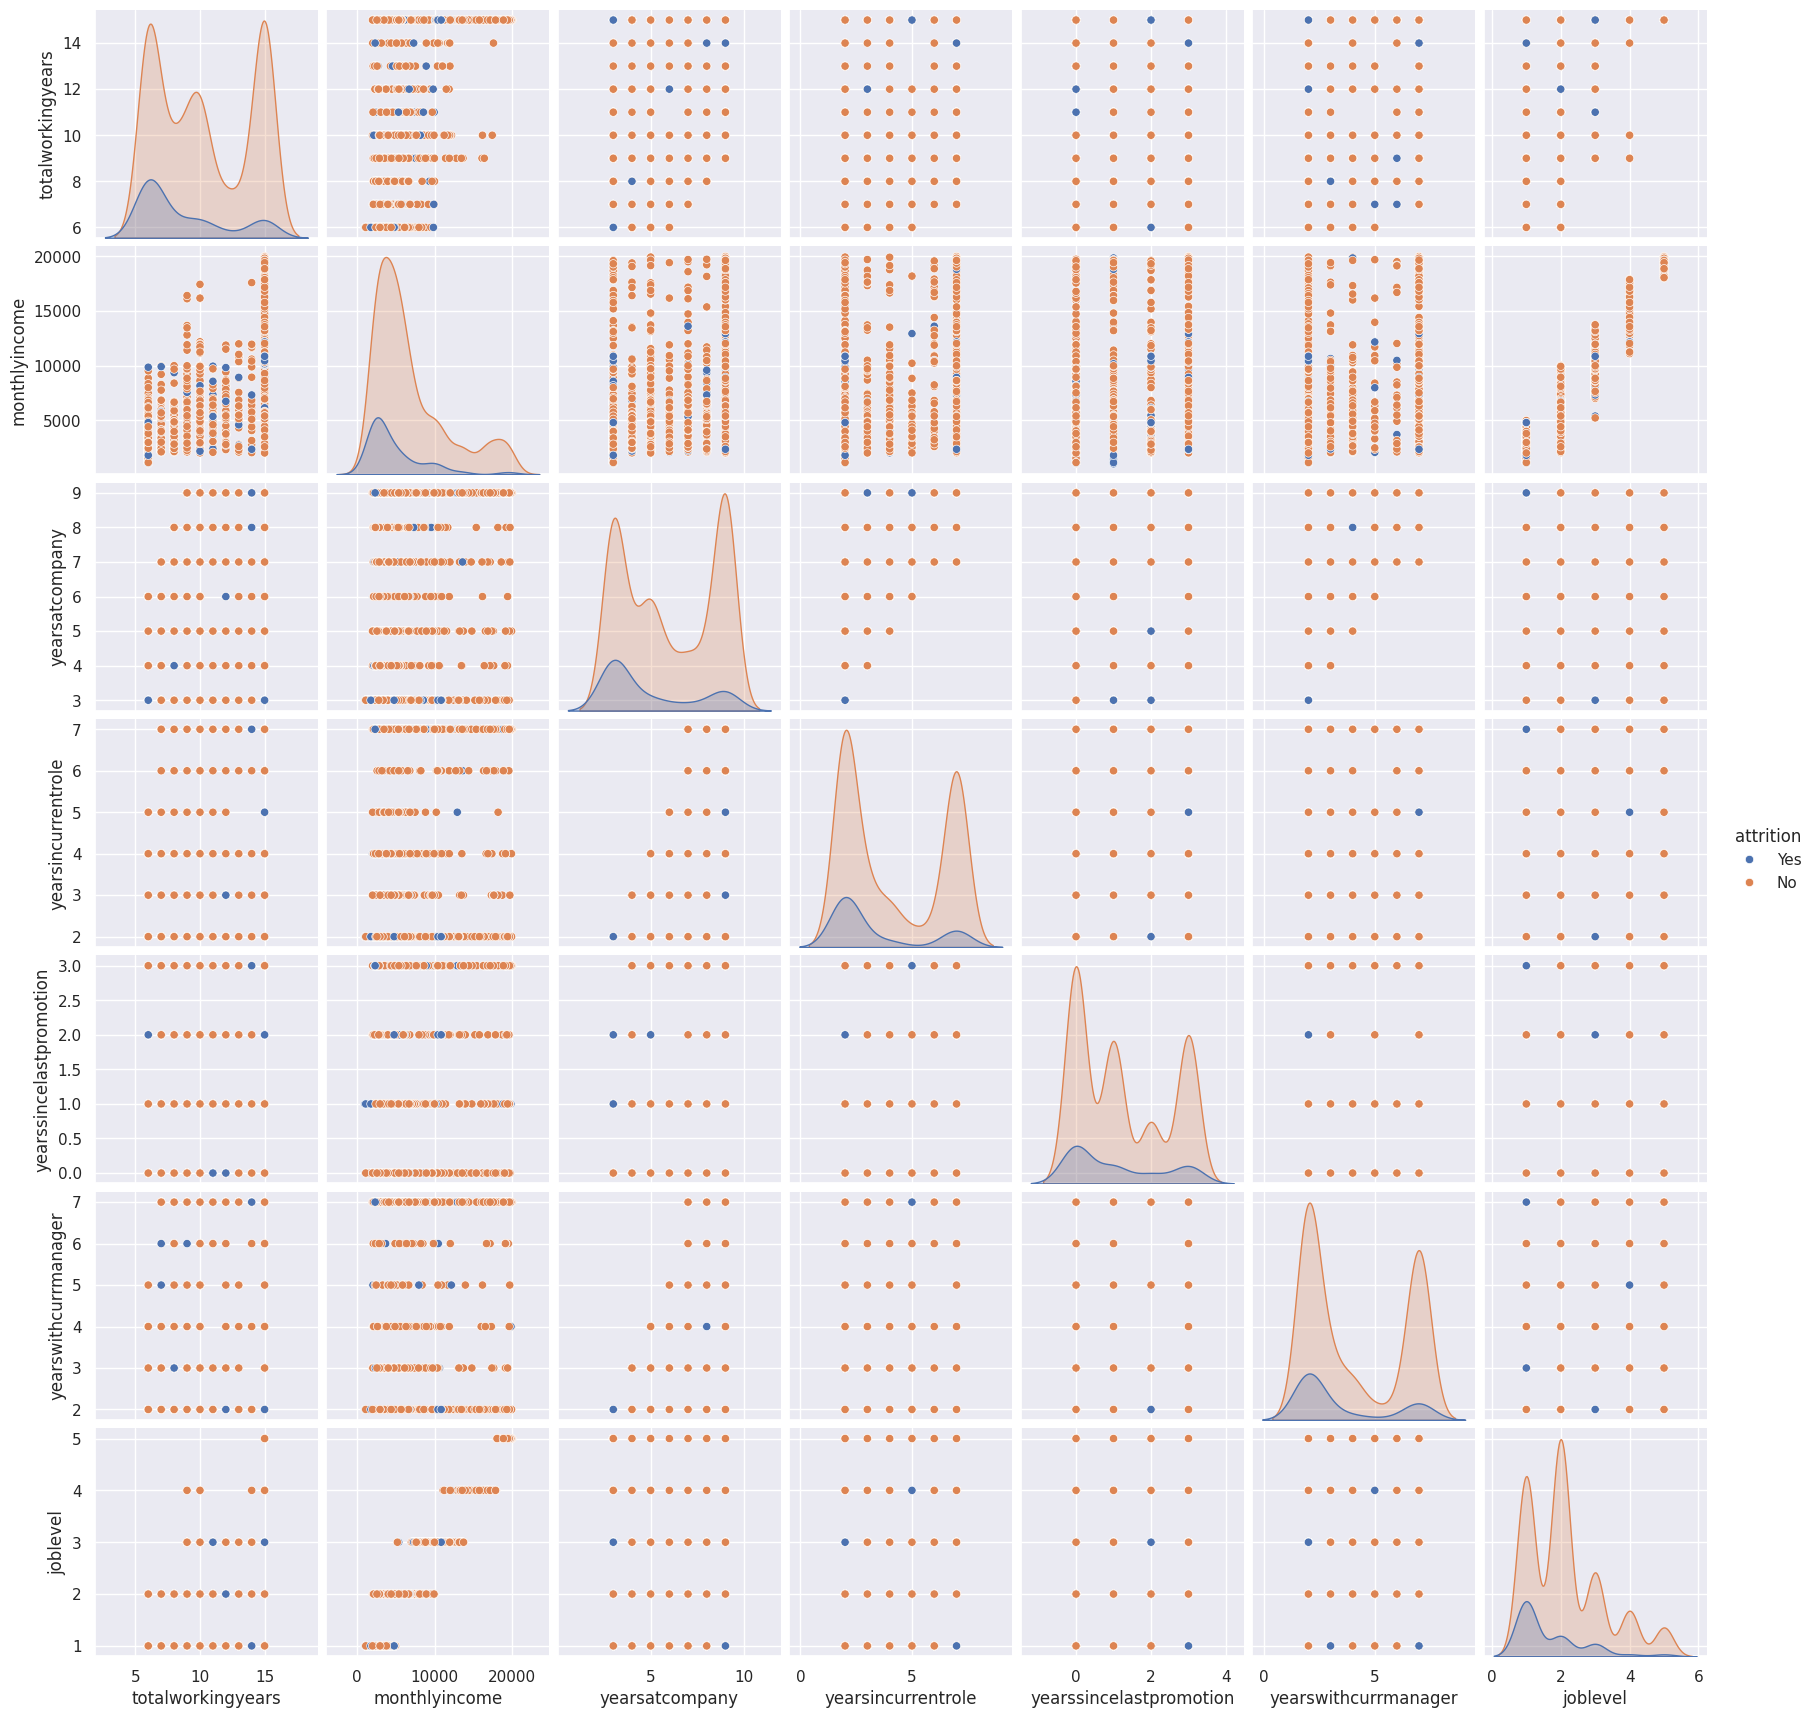

In [57]:
sns.set_context(font_scale=0.75, rc={"figure.figsize": (20, 20)})
subset = ['totalworkingyears',
 'monthlyincome',
 'yearsatcompany',
 'yearsincurrentrole',
 'yearssincelastpromotion',
 'yearswithcurrmanager', 'joblevel']

df_pairplot = pd.concat([df1[subset], df1['attrition']], axis=1)
sns.pairplot(df_pairplot, hue="attrition", height=2.5)

### Explore Correlation

- Plotting the Heatmap

**Exercise 7: Visualize the correlation among IBM employee attrition numerical features using a heatmap [0.5 Mark]**

<Axes: >

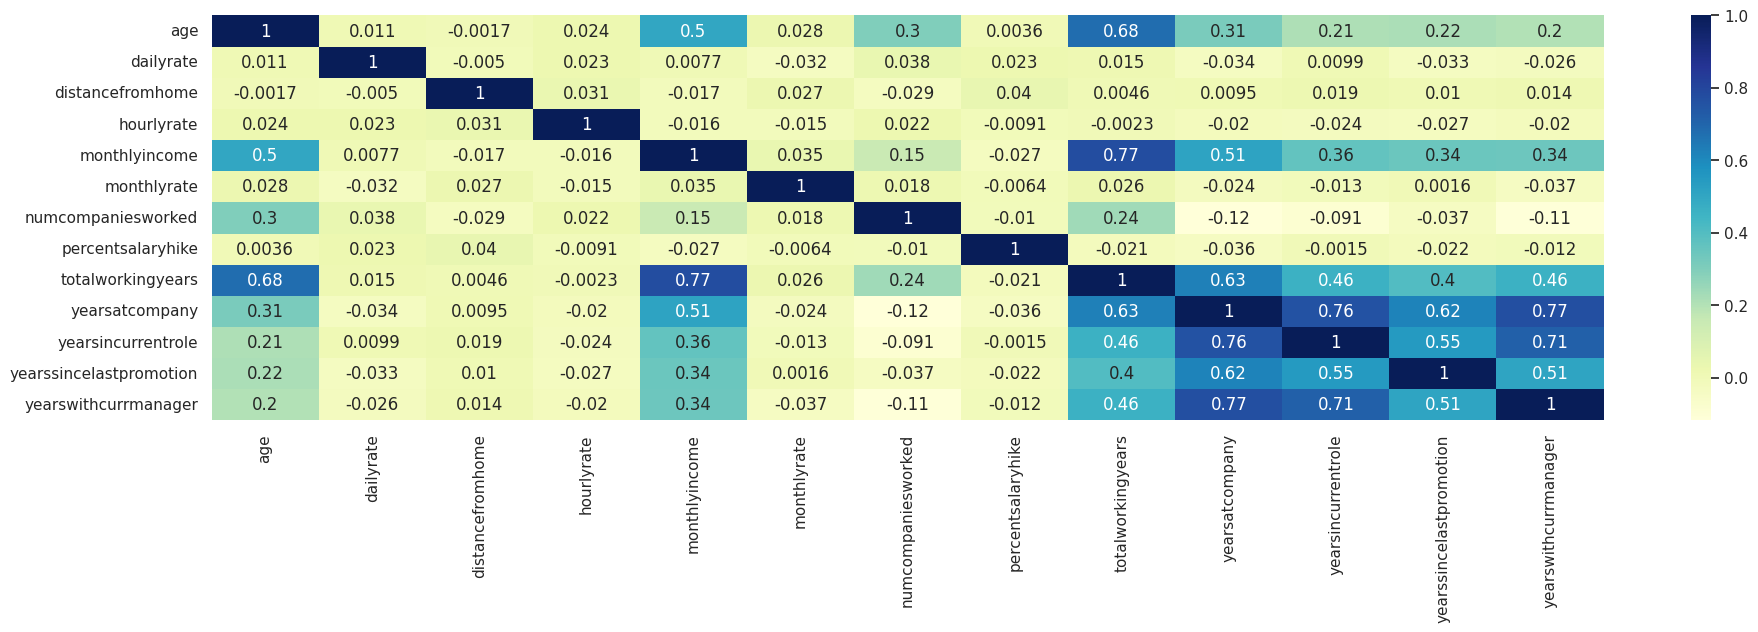

In [63]:
# Visualize heatmap
fig, ax = plt.subplots(figsize=(20,5))

subset = ['age','dailyrate',
 'distancefromhome',
 'hourlyrate',
 'monthlyincome',
 'monthlyrate',
 'numcompaniesworked',
 'percentsalaryhike','totalworkingyears', 'yearsatcompany', 'yearsincurrentrole', 'yearssincelastpromotion', 'yearswithcurrmanager']

data_1 = data[subset].corr()
sns.set_context(font_scale=0.5)
sns.heatmap(data_1, cmap="YlGnBu", annot=True, ax=ax)

From the above heat map, it is clearly seen that features like "yearsatcompany", "yearswithcurrmanager" are highly correlated and hence one of them can be dropped. Similarly, all others where high correlation is observed, features can be dropped.

In [64]:
data_1["yearsatcompany"].sort_values(ascending=True)

numcompaniesworked        -0.118421
percentsalaryhike         -0.035991
dailyrate                 -0.034055
monthlyrate               -0.023655
hourlyrate                -0.019582
distancefromhome           0.009508
age                        0.311309
monthlyincome              0.514285
yearssincelastpromotion    0.618409
totalworkingyears          0.628133
yearsincurrentrole         0.758754
yearswithcurrmanager       0.769212
yearsatcompany             1.000000
Name: yearsatcompany, dtype: float64

Comment on the observations made with the pairplot and heatmap

# Part-B

### Preparing the test feature space
* Remove outliers if any
* Handle the categorical feature if required
* Other processing steps can also be followed.

In [66]:
## NOTE: Final data to be used for training the model is df_final.it is the processed data after outlier treatment and one-hot encoding.
##       It contains emoployee number, which should not be used during modeling.
##       There are two columns for monthly income, monthlyinc_capping and monthlyinc_binning. Training has to be done separately for both by creating two different dataframe-one with
##       binning and other with capping

In [18]:
# YOUR CODE HERE

Optional:
Use `Hyperopt`, a hyperparameter tuning technique to identify the best set of parameters.

In the notebook, data processing is done separately for different models.
Considering the fact that different models may require data in different format and in turn different processes may be followed to process the data.

If the processing steps followed for the models are same, data processing can also be done once.

## Apply CatBoost

Catboost was released in 2017 by Yandex, showing, by their benchmark to be faster in prediction, better in accuracy, and easier to use for categorical data across a series of GBDT tasks. Additional capabilities of catboost include plotting feature interactions and object (row) importance.

[Here](https://catboost.ai/en/docs/) is the official documentation of CatBoost

### Data Processing for CatBoost

**Exercise 8: Data processing for CatBoost [1 Mark]**
* **Copy the dataframe that was created after removing the outliers**
* **Handle the categorical features if required**
* **Create target column and feature space**

**Hint:** Column containing the information on attrition will be the target column.

In [19]:
# Copy the data
# YOUR CODE HERE

In [20]:
# Target Column
# YOUR CODE HERE

In [21]:
# Feature Space
# YOUR CODE HERE

### Model Definition

**Exercise 9: Define, train the model and display the results [2 Mark]**

**Hint:**
* Use CatBoostClassifier() to define the model with relevant parameters.
* Use `fit` to fit the data to the model. Refer [here](https://catboost.ai/en/docs/concepts/speed-up-training) to see some ways to speedup CatBoost training.
* Evaluate the model using roc_auc_score, accuracy_score, f1_score, predict methods or other relevant techniques.

In [22]:
# Create CatBoost model
# YOUR CODE HERE

In [23]:
# Model training
# YOUR CODE HERE

### Model performance

In [24]:
# Model performance on all sets
# YOUR CODE HERE

## Apply XGBoost

XGBoost is a workhorse gradient boosted decision tree algorithm. Its been around since 2014 and has come to dominate the Kaggle and data science community. XGB introduced gradient boosting where new models are fit to the residuals of prior models and then added together, using a gradient descent algorithm to minimize the loss.

Read [here](https://xgboost.readthedocs.io/en/stable/parameter.html) on XGBoost parameters.

Refer [here](https://xgboost.readthedocs.io/en/stable/python/python_api.html#xgboost.XGBClassifier) for the official documentation of XGBoost classifier.

### Data Processing for XGBoost


**Exercise 10: Data Processing for XGBoost [1 Mark]**
* **Copy the dataframe after the outliers were removed.**
* **Handle the categorical features if required**
* **Create target column and feature space**

In [25]:
# Copy dataframe
# YOUR CODE HERE

**Hint:** Use pd.get_dummies

In [26]:
# Handling categorical features
# YOUR CODE HERE

In [27]:
# Concat the dummy variables to actual dataframe and remove initial categorical columns
# YOUR CODE HERE

When creating the dummy variables, the name of attrition column was changed, rename to 'attrition' again.

**Hint:** Use .rename

In [28]:
# Rename target column
# YOUR CODE HERE

In [29]:
# Feature Space
# YOUR CODE HERE

# Targer label
# YOUR CODE HERE

### Model Definition

**Exercise 11: Define, train the model and display the results [2 Mark]**

**Hint:**
* Use XGBClassifier() to define the model with relevant parameters.
* Use `fit` to fit the data to the model.
* Evaluate the model using roc_auc_score, accuracy_score, f1_score, predict methods or other relevant techniques.

In [30]:
# Create XGBoost classifier model
# YOUR CODE HERE

In [31]:
# Model training
# YOUR CODE HERE

### Model Performance

In [32]:
# Model performance on all sets
# YOUR CODE HERE

## Apply LightGBM (Optional)

LightGBM is an open-source GBDT framework created by Microsoft as a fast and scalable alternative to XGB and GBM. By default LightGBM will train a Gradient Boosted Decision Tree (GBDT), but it also supports random forests, Dropouts meet Multiple Additive Regression Trees (DART), and Gradient Based One-Side Sampling (Goss).

To know more about LightGBM parameters, refer [here](https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html#lightgbm.LGBMClassifier).

### Feature Engineering for LightGBM

In [33]:
## Following the same procedure as followed in XGBoost

# Copy the dataframe
# YOUR CODE HERE

# Handling categorical features
# YOUR CODE HERE

# Concat the dummy variables to actual dataframe and remove initial categorical columns
# YOUR CODE HERE

# Rename target column
# YOUR CODE HERE

# Features Space
# YOUR CODE HERE

# Target Label
# YOUR CODE HERE

### Model Definition

**Hint:**
* Use LGBMClassifier() to define the model with relevant parameters.
* Use `fit` to fit the data to the model.
* Evaluate the model using roc_auc_score, accuracy_score, f1_score, predict methods or other relevant techniques.

In [34]:
# Create LightGBM classifier model
# YOUR CODE HERE

In [35]:
# Model training
# YOUR CODE HERE

### Model performance

In [36]:
# Model performance on all sets
# YOUR CODE HERE

## Results

**Exercise 12: Create a dataframe of XGBoost results and CatBoost results and display them [0.5 Mark]**

**Hint:** Use pd.DataFrame

In [37]:
# Create a dataframe for computed metrics for different models
# YOUR CODE HERE

Reference reading:
1. https://machinelearningmastery.com/xgboost-for-imbalanced-classification/